# Classifying League of Legends Champion Archetypes

Read more at: https://chengxi600.medium.com/classifying-league-of-legends-champion-archetypes-with-neural-networks-7e8f680c1efe

In [2]:
import numpy as np
import pandas as pd
import json
from PIL import Image
from os import listdir
from tqdm import tqdm
import cv2



In [3]:
img_path_loading = 'drive/MyDrive/loading/'
img_path_tiles = 'drive/MyDrive/tiles/'
img_path_icon = 'drive/MyDrive/champion/'
data_path = 'drive/MyDrive/champion.json'

Loading champion data, original source from: https://developer.riotgames.com/docs/lol#data-dragon_data-asset

In [4]:
with open(data_path) as f:
  champion_data = json.load(f)

Champion data of 'XinZhao':

In [4]:
champion_data['data']['XinZhao']

{'blurb': 'Xin Zhao is a resolute warrior loyal to the ruling Lightshield dynasty. Once condemned to the fighting pits of Noxus, he survived countless gladiatorial bouts, but after being freed by Demacian forces, he swore his life and allegiance to these brave...',
 'id': 'XinZhao',
 'image': {'full': 'XinZhao.png',
  'group': 'champion',
  'h': 48,
  'sprite': 'champion4.png',
  'w': 48,
  'x': 192,
  'y': 96},
 'info': {'attack': 8, 'defense': 6, 'difficulty': 2, 'magic': 3},
 'key': '5',
 'name': 'Xin Zhao',
 'partype': 'Mana',
 'stats': {'armor': 35,
  'armorperlevel': 3.5,
  'attackdamage': 66,
  'attackdamageperlevel': 3,
  'attackrange': 175,
  'attackspeed': 0.645,
  'attackspeedperlevel': 3.5,
  'crit': 0,
  'critperlevel': 0,
  'hp': 570,
  'hpperlevel': 92,
  'hpregen': 8,
  'hpregenperlevel': 0.7,
  'movespeed': 345,
  'mp': 274,
  'mpperlevel': 55,
  'mpregen': 7.26,
  'mpregenperlevel': 0.45,
  'spellblock': 32,
  'spellblockperlevel': 1.25},
 'tags': ['Fighter', 'Assassi

Building a dict of sample data and labels:

In [51]:
champions = {}
target_names = set()

#Finding the labels from Riot's champion data
for champ in champion_data['data'].keys():
  target_names.add(champion_data['data'][champ]['tags'][0])

target_names = np.array(list(target_names))
champions['target_names'] = target_names
champions

{'target_names': array(['Fighter', 'Assassin', 'Marksman', 'Support', 'Mage', 'Tank'],
       dtype='<U8')}

In [8]:
#what a pixel looks like
twitch = np.asarray(Image.open(img_path_loading + 'Twitch_4.jpg'))
twitch[100][100]

array([208, 174, 113], dtype=uint8)

In [29]:
def add_new_samples_labels(sample_key, label_key, img_path, shape, color_scale, delim):
  ''' Add samples and labels to the champions dictionary
  Args:
  - sample_key (String): key of samples to be added
  - label_key (String): key of labels of sample to be added
  - img_path (String): path to the directory of images
  - shape (tuple): width and height of image
  - color_scale (int): a cv2 constant of the color scale
  - delim (String): deliminator for getting champion name out of file name
  
  Return:
  - champions (Dict): updated dictionary with new samples and labels
  '''
  #use python array for faster appending
  champions[sample_key] = []
  champions[label_key] = []

  #iterate through files in path
  for sample in tqdm(listdir(img_path)):
    
    #get champion name
    champ = sample.split(delim)[0]
    
    #get label from champion data 
    try:
      tag = champion_data['data'][champ]['tags'][0]
    except KeyError:
      tag = champion_data['data'][champ.title()]['tags'][0]
    
    #get feature data
    img = cv2.imread(img_path + sample, color_scale)
    sample_data = cv2.resize(img, dsize=shape, interpolation=cv2.INTER_CUBIC)

    champions[sample_key].append(sample_data)
    champions[label_key].append(np.where(champions['target_names']==tag)[0][0])

  #convert array to numpy array for compatibility with other libraries
  champions[sample_key] = np.array(champions[sample_key])
  champions[label_key] = np.array(champions[label_key])
  return champions

Adding samples to dict:

In [ ]:
add_new_samples_labels('images_loading', 'target_loading', img_path_loading, (32, 32), cv2.IMREAD_COLOR, '_')

In [ ]:
add_new_samples_labels('images_icon', 'target_icon', img_path_icon, (32, 32), cv2.IMREAD_GRAYSCALE, '.')
add_new_samples_labels('images_tiles', 'target_tiles', img_path_tiles, (224, 224), cv2.IMREAD_COLOR, '_')

In [53]:
print('Num classes: ' + str(champions['target_names'].shape))
print('images shape: ' + str(champions['images_tiles'].shape))
print('target shape: ' + str(champions['target_tiles'].shape))

Num classes: (6,)
images shape: (1377, 227, 227, 3)
target shape: (1377,)


In [54]:
from sklearn.model_selection import train_test_split
from numpy.random import seed
from tensorflow.random import set_seed
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns

seed(4100)
set_seed(4100)

In [44]:
features_train, features_test, labels_train, labels_test = train_test_split(champions['images_tiles'], champions['target_tiles'], test_size=0.1, random_state=4100)

In [45]:
# Model / data parameters
num_classes = len(champions['target_names'])
input_shape = (32, 32, 1)

# Scale images to the [0, 1] range
features_train = features_train.astype("float32") / 255
features_test = features_test.astype("float32") / 255

# Make sure images have shape (32, 32, 1)
features_train = np.expand_dims(features_train, -1)
features_test = np.expand_dims(features_test, -1)

print("x_train shape:", features_train.shape)
print(features_train.shape[0], "train samples")
print(features_test.shape[0], "test samples")

labels_train = keras.utils.to_categorical(labels_train, num_classes)
labels_test = keras.utils.to_categorical(labels_test, num_classes)

x_train shape: (1239, 32, 32, 1)
1239 train samples
138 test samples


In [46]:
lenet_model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

lenet_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 2304)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                

In [47]:
batch_size = 128
epochs = 100

lenet_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history_lenet = lenet_model.fit(features_train, labels_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/100
9/9 [==============================] - 2s 148ms/step - loss: 1.7463 - accuracy: 0.2323 - val_loss: 1.7018 - val_accuracy: 0.3226
Epoch 2/100
9/9 [==============================] - 1s 131ms/step - loss: 1.7340 - accuracy: 0.2655 - val_loss: 1.7199 - val_accuracy: 0.3145
Epoch 3/100
9/9 [==============================] - 1s 130ms/step - loss: 1.7292 - accuracy: 0.2610 - val_loss: 1.7052 - val_accuracy: 0.3145
Epoch 4/100
9/9 [==============================] - 1s 132ms/step - loss: 1.7166 - accuracy: 0.2780 - val_loss: 1.7117 - val_accuracy: 0.3065
Epoch 5/100
9/9 [==============================] - 1s 133ms/step - loss: 1.7108 - accuracy: 0.2789 - val_loss: 1.7075 - val_accuracy: 0.3387
Epoch 6/100
9/9 [==============================] - 1s 131ms/step - loss: 1.6945 - accuracy: 0.2807 - val_loss: 1.7060 - val_accuracy: 0.3145
Epoch 7/100
9/9 [==============================] - 1s 133ms/step - loss: 1.6941 - accuracy: 0.2789 - val_loss: 1.7170 - val_accuracy: 0.2742
Epoch 8/100
9

In [48]:
score = lenet_model.evaluate(features_test, labels_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 2.376610517501831
Test accuracy: 0.28260868787765503


In [17]:
history_lenet.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

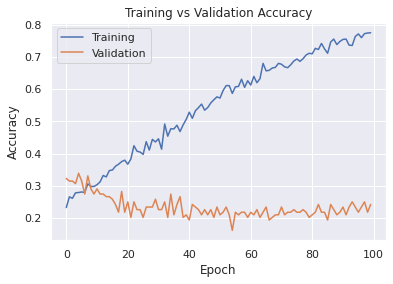

In [49]:
sns.set()
plt.plot(history_lenet.history['accuracy'])
plt.plot(history_lenet.history['val_accuracy'])
plt.title('Training vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'])
plt.savefig('lenet_hist1.png')
plt.show()

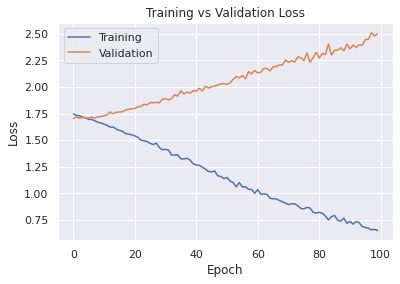

In [50]:

plt.plot(history_lenet.history['loss'])
plt.plot(history_lenet.history['val_loss'])
plt.title('Training vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'])
plt.savefig('lenet_hist2.png')
plt.show()

In [68]:
features_train, features_test, labels_train, labels_test = train_test_split(champions['images_tiles'], champions['target_tiles'], test_size=0.1, random_state=4100)

In [69]:
# Model / data parameters
num_classes = len(champions['target_names'])
input_shape = champions['images_tiles'][0].shape

# Scale images to the [0, 1] range
features_train = features_train.astype("float32") / 255
features_test = features_test.astype("float32") / 255

print("x_train shape:", features_train.shape)
print(features_train.shape[0], "train samples")
print(features_test.shape[0], "test samples")

labels_train = keras.utils.to_categorical(labels_train, num_classes)
labels_test = keras.utils.to_categorical(labels_test, num_classes)

x_train shape: (1239, 224, 224, 3)
1239 train samples
138 test samples


In [57]:
alexnet_model = keras.models.Sequential(
    [
      keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=input_shape),
      keras.layers.BatchNormalization(),
      keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
      keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
      keras.layers.BatchNormalization(),
      keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
      keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
      keras.layers.BatchNormalization(),
      keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
      keras.layers.BatchNormalization(),
      keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
      keras.layers.BatchNormalization(),
      keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
      keras.layers.Flatten(),
      keras.layers.Dense(4096, activation='relu'),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(4096, activation='relu'),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(num_classes, activation='softmax')
    ]
)
alexnet_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 55, 55, 96)        384       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 27, 256)       1024      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 13, 13, 384)      

In [58]:
batch_size = 128
epochs = 50

alexnet_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = alexnet_model.fit(features_train, labels_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/50
9/9 [==============================] - 175s 19s/step - loss: 43.5239 - accuracy: 0.1767 - val_loss: 155.7712 - val_accuracy: 0.1452
Epoch 2/50
9/9 [==============================] - 169s 19s/step - loss: 4.6660 - accuracy: 0.2027 - val_loss: 20.3349 - val_accuracy: 0.2016
Epoch 3/50
9/9 [==============================] - 170s 19s/step - loss: 2.8942 - accuracy: 0.2413 - val_loss: 5.3148 - val_accuracy: 0.2742
Epoch 4/50
9/9 [==============================] - 175s 20s/step - loss: 2.4061 - accuracy: 0.2502 - val_loss: 4.3242 - val_accuracy: 0.1371
Epoch 5/50
9/9 [==============================] - 171s 19s/step - loss: 2.0128 - accuracy: 0.2843 - val_loss: 2.8363 - val_accuracy: 0.2258
Epoch 6/50
9/9 [==============================] - 170s 19s/step - loss: 1.9705 - accuracy: 0.2897 - val_loss: 2.3689 - val_accuracy: 0.1452
Epoch 7/50
9/9 [==============================] - 172s 19s/step - loss: 1.8579 - accuracy: 0.2870 - val_loss: 1.9364 - val_accuracy: 0.2661
Epoch 8/50
9/9 [

In [59]:
score = alexnet_model.evaluate(features_test, labels_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 2.3671555519104004
Test accuracy: 0.26811593770980835


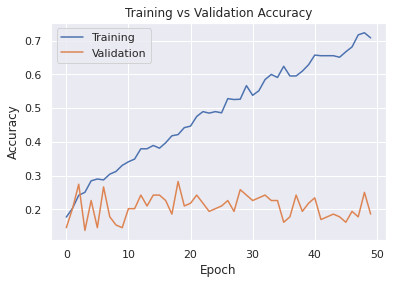

In [60]:
sns.set()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'])
plt.savefig('alex_hist1.png')
plt.show()

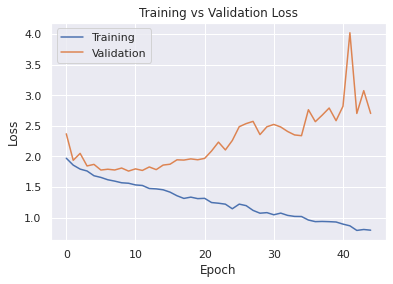

In [63]:

plt.plot(history.history['loss'][5:])
plt.plot(history.history['val_loss'][5:])
plt.title('Training vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'])
plt.savefig('alex_hist2.png')
plt.show()